In [1]:
import torch

print("Torch version:",torch.__version__)
print("Is CUDA enabled?",torch.cuda.is_available())

Torch version: 2.0.1+cu118

Is CUDA enabled? True


In [2]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1

NVIDIA GeForce RTX 2060


In [3]:
import numpy as np
import pandas as pd
import langid
import emoji
import matplotlib.pylab as plt
from collections import Counter
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

import torch, os
from torch.utils.data import Dataset

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from nltk import download, word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from wordcloud import WordCloud
import warnings

warnings.filterwarnings("ignore")
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'svg'
# download(['punkt','vader_lexicon'])

[nltk_data] Downloading package stopwords to C:\Users\Shafakat

[nltk_data]     Arnob\AppData\Roaming\nltk_data...

[nltk_data]   Package stopwords is already up-to-date!

[nltk_data] Downloading package punkt to C:\Users\Shafakat

[nltk_data]     Arnob\AppData\Roaming\nltk_data...

[nltk_data]   Package punkt is already up-to-date!

c:\Users\Shafakat Arnob\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

DATA PRE-PROCESSING

In [5]:
ROOT_DIR = '../'

df_org= pd.read_csv(ROOT_DIR + "train.csv")

df_org = df_org.sample(frac=1.0, random_state=42)

df_org.head()

,summary,genre,Label
1344,#রকমারি_বইপোকা_রিভিউ_প্রতিযোগিতা\r\n\r\n|| রিভ...,Thriller,1
3824,একাত্তরের মুক্তিযুদ্ধ ছিল একটি মহাযজ্ঞ। এই যজ্...,War,5
3030,বই - ড্রাগন\r\nলেখক - ক্লাইভ কাসলার\r\nঅনুবাদ ...,Thriller,1
3618,‘গনতন্ত্রের অমসৃণ পথ’ বইটির লেখক সিরাজুল ইসলাম...,Political,3
1813,"একাত্তরের মুক্তিযুদ্ধ, রক্তাক্ত মধ্য আগষ্ট ও ষ...",War,5


In [6]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>

Index: 3887 entries, 1344 to 3174

Data columns (total 3 columns):

 #   Column   Non-Null Count  Dtype 

---  ------   --------------  ----- 

 0   summary  3886 non-null   object

 1   genre    3887 non-null   object

 2   Label    3887 non-null   int64 

dtypes: int64(1), object(2)

memory usage: 121.5+ KB


In [7]:
df_org.shape

(3887, 3)

In [8]:
uni=df_org.genre.unique()
print(f"Categories of Trainset: {uni} and Count: {len(uni)}")

Categories of Trainset: ['Thriller' 'War' 'Political' 'Fiction' 'Childrens-Book' 'Science-Fiction'

 'Motivational'] and Count: 7


In [9]:
df_org.isna().sum()

summary    1
genre      0
Label      0
dtype: int64

In [11]:
df_org.dropna(inplace=True)

In [12]:
# Drop summary length below 5

df_org['count'] = df_org['summary'].str.split().str.len()
df_org= df_org.loc[df_org['count']>5]

In [13]:
df_org.shape

(3760, 4)

In [14]:
df_org.head()

,summary,genre,Label,count
1344,#রকমারি_বইপোকা_রিভিউ_প্রতিযোগিতা\r\n\r\n|| রিভ...,Thriller,1,533
3824,একাত্তরের মুক্তিযুদ্ধ ছিল একটি মহাযজ্ঞ। এই যজ্...,War,5,752
3030,বই - ড্রাগন\r\nলেখক - ক্লাইভ কাসলার\r\nঅনুবাদ ...,Thriller,1,327
3618,‘গনতন্ত্রের অমসৃণ পথ’ বইটির লেখক সিরাজুল ইসলাম...,Political,3,261
1813,"একাত্তরের মুক্তিযুদ্ধ, রক্তাক্ত মধ্য আগষ্ট ও ষ...",War,5,600


In [15]:
df = pd.DataFrame(df_org['summary'])

def is_english(text):
    language, confidence = langid.classify(text)
    return language == 'en'

df['is_english'] = df['summary'].apply(is_english)

english_count = df['is_english'].sum()
english_indices = df.loc[df['is_english']].summary

print(f"Row indices with fully English text: \n{english_indices}")

Row indices with fully English text: 

3063                I Love Reading books Very Very much 💖

3671    Not as a my friend of the writer, I would say ...

495     The main character Jasmhed is Darbish himself,...

567     Enjoyed reading. Even though some of the chara...

2500    i've been looking for the book কত অজানারে by শ...

                              ...                        

1400    I have grown up reading Md Zafar Iqbal's books...

1663                          What a book! Worth the time

3627    one of the few books that makes you feel empty...

1955    Starting was good...climax ending was totally ...

1390    After a long time I have read a book with huge...

Name: summary, Length: 98, dtype: object


In [16]:
print(f"Number of cells with fully English text: {english_count}")

Number of cells with fully English text: 98


In [17]:
df_org['is_english'] = df['is_english']

In [18]:
df_org = df_org[df_org['is_english'] != True]

In [20]:
df_org.shape

(3662, 5)

In [21]:
df_org.head()

,summary,genre,Label,count,is_english
1344,#রকমারি_বইপোকা_রিভিউ_প্রতিযোগিতা\r\n\r\n|| রিভ...,Thriller,1,533,False
3824,একাত্তরের মুক্তিযুদ্ধ ছিল একটি মহাযজ্ঞ। এই যজ্...,War,5,752,False
3030,বই - ড্রাগন\r\nলেখক - ক্লাইভ কাসলার\r\nঅনুবাদ ...,Thriller,1,327,False
3618,‘গনতন্ত্রের অমসৃণ পথ’ বইটির লেখক সিরাজুল ইসলাম...,Political,3,261,False
1813,"একাত্তরের মুক্তিযুদ্ধ, রক্তাক্ত মধ্য আগষ্ট ও ষ...",War,5,600,False


In [22]:
# Removing Punctuations

def remove_punctuations(text, is_english):
    if not is_english:
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F700-\U0001F77F"  # alchemical symbols
                                   u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                                   u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                                   u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                                   u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                                   u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                                   u"\U00002702-\U000027B0"  # Dingbats
                                   u"\U000024C2-\U0001F251"
                                   "]+", flags=re.UNICODE)
        text = emoji_pattern.sub(r'', text)

        whitespace = re.compile(u"[\s\u0020\u00a0\u1680\u180e\u202f\u205f\u3000\u2000-\u200a]+", re.UNICODE)
        bangla_fullstop = u"\u0964"
        bangla_taka = u"\u09F3"
        punctSeq = u"['\"“”‘’]+|[.?!,…]+|[:;]+"
        punc = u"[(),$%^&*+={}\[\]:\"\৷|\'\~`<>/,¦!?½£¶¼©⅐⅑⅒⅓⅔⅕⅖⅗⅘⅙⅚⅛⅜⅝⅞⅟↉¤¿º;-]+"

        text = re.sub(r'(^|\s)@(\w+)', r'\1@user', text)
        text = re.sub(r'\bhttps?://\S+\b', '', text)
        text = re.sub(punctSeq, " ", text)
        text = re.sub(bangla_fullstop, " ", text)
        text = re.sub(bangla_taka, " ", text)
        text = re.sub(punc, " ", text)
        text = re.sub('[!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~]', ' ', text)
        bangla_numeric = u"\u09E6-\u09EF"  # Range of Bangla numeric characters
        text = re.sub(f"[{bangla_numeric}]+", "", text)
        text = text.replace("\\", " ")
        text = whitespace.sub(" ", text).strip()

    else:
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F700-\U0001F77F"  # alchemical symbols
                                   u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                                   u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                                   u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                                   u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                                   u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                                   u"\U00002702-\U000027B0"  # Dingbats
                                   u"\U000024C2-\U0001F251"
                                   "]+", flags=re.UNICODE)
        text = emoji_pattern.sub(r'', text)
        text = re.sub(r'(^|\s)@(\w+)', r'\1@user', text)
        text = re.sub(r'\bhttps?://\S+\b', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = text.lower()

        tokens = word_tokenize(text)
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]
        text = ' '.join(tokens)

    return text

df_org['summary'] = df_org.apply(lambda row: remove_punctuations(row['summary'], row['is_english']), axis=1)


In [23]:
df_org['summary'][6]

'রকমারি বইপোকা রিভিউ প্রতিযোগিতা বইঃ বোতল ভূত লেখকঃ হুমায়ূন আহমেদ প্রকাশনীঃ প্রতীক প্রকাশনা সংস্থা প্রচ্ছদঃ ধ্রুব এষ পৃষ্ঠাঃ মুদ্রিত মুল্যঃ রিভিউঃ বোতল ভূত মূলত শিশু কিশোরদের জন্যে রচিত উপন্যাস মজার ভৌতিক গল্প বললেও ভুল হবে না বইটি পড়ে আমার মনে হয়েছে তা বড়দেরও আনন্দ দিতে পারে সুতারাং বড় ছোট সকলে পড়তে পারেন এই বইটি উপন্যাসে হুমায়ুন আহমেদ উত্তম পুরুষে কাহিনীর বর্ণনা দিয়ে যান একদিন ক্লাসে এগারো বছর বয়সী লেখাপড়ায় বিমুখ হুমায়ুন আহমেদকে তার বন্ধু মুনির অবাক করে দিয়ে বলল এই হুমায়ুন ভূত পুষবি ভূত পুষবে মানে ভূত কি কুকুর ছানা নাকি যা চাইলে সহজে পোষা যায় এমন প্রশ্নগুলো হুমায়ুনের মনে কৌতূহল বাড়াতে থাকে সাথে সাথে সে রাজি হয়ে রওনা দেয় ভুতের বাচ্চা আনতে তখন সন্ধ্যাবেলা গাছপালায় ঢাকা জঙ্গুলে জায়গায় শেওলা ঢাকা দো তলা বাড়িতে তারা উপস্থিত হয় বাড়ির নাম শান্তিনিকেতন দরজায় কড়া নাড়তেই বেরিয়ে আসে সন্ন্যাসীর মতন চেহারার একলোক ঠিক যেন দেখতে অবিকল রবীন্দ্রনাথ ঠাকুরের মতন পরনে আলখাল্লার মত লম্বা পোশাক লোকটির আগে অন্য নাম ছিল এখন অবশ্য সকলে রবিবাবু নামেই ডাকে কি অদ্ভুত তাই না সেই অদ্ভুত লোকটিই ছোট্ট শিশিতে ভরে দি

In [24]:
not_imp_word = ['রকমারি', 'লিঙ্কঃ','রিভিউ','লেখকঃ','প্রকাশনীঃ', 'প্রচ্ছদঃ', 'পৃষ্ঠাঃ', 'মুল্যঃ','রিভিউঃ','রেটিং','বইঃ','মুদ্রিত','প্রকাশনা', 'সুতারাং', 'নামঃ']

In [25]:
from collections import Counter
cnt = Counter()
for text in df_org['summary'].values:
    for word in text.split():
        cnt[word] += 1
sorted_cnt = dict(sorted(cnt.items(), key=lambda item: item[1], reverse= True))
sorted_cnt = Counter(sorted_cnt)
print('Total Unique Words:', len(sorted_cnt))

Total Unique Words: 72315


In [26]:
# Before removing not important words

print('Top 15 frequent words:')
for word, frequency in sorted_cnt.most_common(15):
    print(f'{word}: {frequency}')

Top 15 frequent words:

তার: 12294

এই: 12005

করে: 11833

না: 10956

আর: 8894

এক: 7751

ও: 6711

থেকে: 6557

সে: 6314

কিন্তু: 6251

হয়: 5893

এবং: 5718

যে: 5558

একটা: 5108

সাথে: 5105


In [27]:
stop_word_list = (stopwords.words('bengali'))
stop_word_list+=not_imp_word
def stopword_remover(doc):
	tokens = doc.split()
	stop_words = stop_word_list
	tokens = [w for w in tokens if not w in stop_words]
	tokens = ' '.join(tokens)
	return tokens
df_org['summary'] = df_org.summary.apply(stopword_remover)

In [28]:
from collections import Counter
cnt = Counter()
for text in df_org['summary'].values:
    for word in text.split():
        cnt[word] += 1
sorted_cnt = dict(sorted(cnt.items(), key=lambda item: item[1], reverse= True))
sorted_cnt = Counter(sorted_cnt)
print('Total Unique Words:', len(sorted_cnt))

Total Unique Words: 71919


In [29]:
# After removing not important words

print('Top 30 frequent words:')
for word, frequency in sorted_cnt.most_common(30):
    print(f'{word}: {frequency}')

Top 30 frequent words:

এক: 7751

একটা: 5108

সাথে: 5105

যায়: 4537

বই: 4366

লেখক: 4313

হয়ে: 4001

কথা: 3474

বইটি: 3353

হয়েছে: 3094

একজন: 2634

পড়ে: 2629

উপন্যাস: 2614

ভালো: 2573

গল্প: 2554

শেষ: 2419

মানুষ: 2250

নাম: 2232

লেখা: 2218

দিয়ে: 2170

সময়: 1945

বইয়ের: 1917

মানুষের: 1858

কাহিনী: 1740

মত: 1616

চরিত্র: 1611

হিসেবে: 1576

উপন্যাসের: 1575

জীবন: 1551

বড়: 1498


In [30]:
print('Top 15 least frequent words:')

for word, frequency in sorted_cnt.most_common()[:-16:-1]:
    print(f'{word}: {frequency}')

Top 15 least frequent words:

দুর্বলতাকেই: 1

সমুদ্রসম: 1

ভুক্তিগুলির: 1

অক্ষরক্রম: 1

গ্রন্থপঞ্জি: 1

ভুক্তিতে: 1

সংস্করণটিতে: 1

পরিবর্ধনের: 1

ঢাকাঃ: 1

লক্ষেই: 1

এতদসত্ত্বেও: 1

ছবিগুলি: 1

ধূলিকণায়: 1

সুবে: 1

সুবেদের: 1


In [31]:
# After final cleaning

df_org['summary'][7]

'পাঠকনন্দিত লেখক ডক্টর মুহম্মদ জাফর ইকবাল স্যার মূলত সাইন্স ফিকশন লিখে পরিচিত সবাই জানে বিজ্ঞান নিয়েই কারবার লেখা ছোটগল্পের সংখ্যাও নেহাতই কম চিরাচরিত বৈজ্ঞানিক বিশ্বাসকে বুড়ো আঙ্গুল দেখিয়ে আদিভৌতিক চিন্তাভাবনায় ব্যাখাতীত ঘটনার উল্লেখ ঘটে নামক গল্পগ্রন্থে তেমনই টা গল্পের সন্নিবেশন ঘটেছে স্থূল অর্থে বইটিকে ভূতের বই একদমই ভুল কেননা সরাসরি ভূত প্রেতের কথা লেখক একটিবারের জন্যেও গল্পে আনেন নি গল্পগুলোর মানুষের জীবনের ঘটনাকেই ধরতে চেয়েছেন ব্যাখ্যা খুঁজে পাই সেগুলোকে প্যারানরমাল অস্বাভাবিক ঘটনা আখ্যায়িত থাকি এইসব গল্পের আরেকটি বিশেষত্ব হুমায়ুন আহমেদের আদিভৌতিক গল্পে দেখেছে অস্বাভাবিক ঘটনাগুলোর পেছনে অতি স্বাভাবিক প্রভাব ফেলেছে কিনা আলোকপাত হয়েছে মুহম্মদ জাফর ইকবাল গল্পগুলোতে ধরণের ব্যবচ্ছেদের চালান ঘটনাগুলোকে সাদা চোখে দেখায় সেভাবেই ভাষায় উপস্থাপন ব্যাখ্যাতীত ব্যাপার স্যাপারের ব্যাখ্যা খুঁজে বের দায় টেনে নেন পাঠকের উপরই ছেড়ে দিয়েছেন বইয়ের গল্প লেখক এক দুঃসম্পর্কের মামা গহর মামার জবানিতে গল্পটি শুনিয়েছেন গহর মামার যুবক বয়সের গল্প পড়তেন মাদরাসায় কবিরাজি চিকিৎসার জন্যে এক বিচিত্র স্বভাবের ব্যক্ত

DATA VISUALIZATION

<Figure size 1600x1600 with 0 Axes>

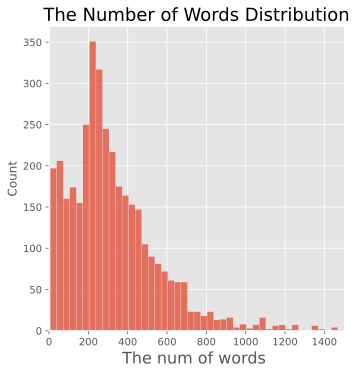

In [33]:
import seaborn as sns

plt.figure(figsize= (16, 16))

sns.displot(df_org['count'])

plt.xlim(0, 1500)

plt.xlabel('The num of words ', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
plt.show()

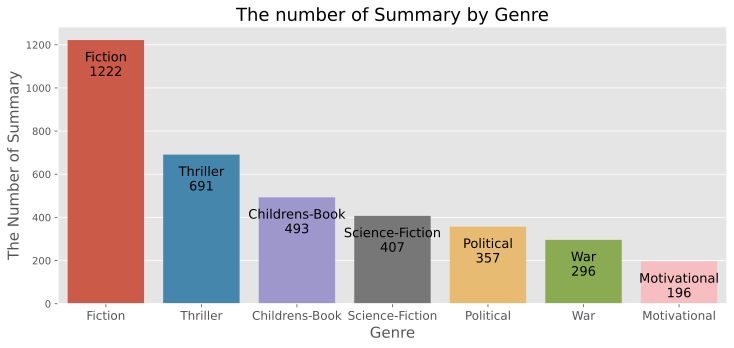

In [34]:
category_count = df_org['genre'].value_counts()

categories = category_count.index

fig = plt.figure(figsize= (12, 5))

ax = fig.add_subplot(111)

sns.barplot(x = category_count.index, y = category_count )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'black' , ha = 'center', va = 'center', textcoords = 'offset points' )

plt.xlabel('Genre', size = 15)

plt.ylabel('The Number of Summary', size= 15)

plt.xticks(size = 12)

plt.title("The number of Summary by Genre" , size = 18)

plt.show()

In [35]:
df_org

,summary,genre,Label,count,is_english
1344,বইপোকা প্রতিযোগিতা বই মিথস্ক্রিয়া লেখক কিশোর প...,Thriller,1,533,False
3824,একাত্তরের মুক্তিযুদ্ধ মহাযজ্ঞ যজ্ঞের কুশীলব ভূ...,War,5,752,False
3030,বই ড্রাগন লেখক ক্লাইভ কাসলার অনুবাদ মখদুম আহমে...,Thriller,1,327,False
3618,গনতন্ত্রের অমসৃণ পথ বইটির লেখক সিরাজুল ইসলাম চ...,Political,3,261,False
1813,একাত্তরের মুক্তিযুদ্ধ রক্তাক্ত মধ্য আগষ্ট ষড়যন...,War,5,600,False
...,...,...,...,...,...
1130,বইয়ের ঢাকা স্মৃতি বিস্তৃতির নগরী য় খণ্ড মুনতাস...,War,5,317,False
1294,হাসি জিনিসটা ভেতর আসে মেকি হাসির কথা ভিন্ন সবস...,Fiction,0,211,False
860,বইপোকা প্রতিযোগিতা নাম নিঃসঙ্গ গ্রহচারী লেখক ম...,Science-Fiction,4,157,False
3507,বইপোকা প্রতিযোগিতা নাম শান্তা পরিবার লেখক মোহম...,Childrens-Book,2,265,False


genre

Childrens-Book      493

Fiction            1222

Motivational        196

Political           357

Science-Fiction     407

Thriller            691

War                 296

Name: count, dtype: int64


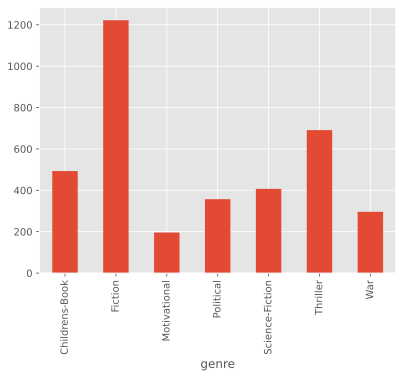

In [36]:
print(df_org['genre'].value_counts().sort_index())
df_org['genre'].value_counts().sort_index().plot(kind='bar')
plt.show()

LABELING

In [37]:
labels = df_org['genre'].unique().tolist()
labels = [s.strip() for s in labels ]
labels

['Thriller',
 'War',
 'Political',
 'Fiction',
 'Childrens-Book',
 'Science-Fiction',
 'Motivational']

In [38]:
for key, value in enumerate(labels):
    print(value)

Thriller

War

Political

Fiction

Childrens-Book

Science-Fiction

Motivational


In [39]:
NUM_LABELS= len(labels)

id2label={id:label for id,label in enumerate(labels)}

label2id={label:id for id,label in enumerate(labels)}

In [40]:
label2id

{'Thriller': 0,
 'War': 1,
 'Political': 2,
 'Fiction': 3,
 'Childrens-Book': 4,
 'Science-Fiction': 5,
 'Motivational': 6}

In [41]:
label2id['Fiction'] = 0
label2id['Thriller'] = 1
label2id['Childrens-Book'] = 2
label2id['Political'] = 3
label2id['Science-Fiction'] = 4
label2id['War'] = 5
label2id['Motivational'] = 6

In [42]:
label2id

{'Thriller': 1,
 'War': 5,
 'Political': 3,
 'Fiction': 0,
 'Childrens-Book': 2,
 'Science-Fiction': 4,
 'Motivational': 6}

In [43]:
id2label

{0: 'Thriller',
 1: 'War',
 2: 'Political',
 3: 'Fiction',
 4: 'Childrens-Book',
 5: 'Science-Fiction',
 6: 'Motivational'}

In [44]:
id2label[0] = 'Fiction'
id2label[1] = 'Thriller'
id2label[2] = 'Childrens-Book'
id2label[3] = 'Political'
id2label[4] = 'Science-Fiction'
id2label[5] = 'War'
id2label[6] = 'Motivational'

In [45]:
id2label

{0: 'Fiction',
 1: 'Thriller',
 2: 'Childrens-Book',
 3: 'Political',
 4: 'Science-Fiction',
 5: 'War',
 6: 'Motivational'}

In [46]:
df_org

,summary,genre,Label,count,is_english
1344,বইপোকা প্রতিযোগিতা বই মিথস্ক্রিয়া লেখক কিশোর প...,Thriller,1,533,False
3824,একাত্তরের মুক্তিযুদ্ধ মহাযজ্ঞ যজ্ঞের কুশীলব ভূ...,War,5,752,False
3030,বই ড্রাগন লেখক ক্লাইভ কাসলার অনুবাদ মখদুম আহমে...,Thriller,1,327,False
3618,গনতন্ত্রের অমসৃণ পথ বইটির লেখক সিরাজুল ইসলাম চ...,Political,3,261,False
1813,একাত্তরের মুক্তিযুদ্ধ রক্তাক্ত মধ্য আগষ্ট ষড়যন...,War,5,600,False
...,...,...,...,...,...
1130,বইয়ের ঢাকা স্মৃতি বিস্তৃতির নগরী য় খণ্ড মুনতাস...,War,5,317,False
1294,হাসি জিনিসটা ভেতর আসে মেকি হাসির কথা ভিন্ন সবস...,Fiction,0,211,False
860,বইপোকা প্রতিযোগিতা নাম নিঃসঙ্গ গ্রহচারী লেখক ম...,Science-Fiction,4,157,False
3507,বইপোকা প্রতিযোগিতা নাম শান্তা পরিবার লেখক মোহম...,Childrens-Book,2,265,False


In [47]:
df_org["labels"]=df_org['genre'].map(lambda x: label2id[x.strip()])

In [48]:
df_org

,summary,genre,Label,count,is_english,labels
1344,বইপোকা প্রতিযোগিতা বই মিথস্ক্রিয়া লেখক কিশোর প...,Thriller,1,533,False,1
3824,একাত্তরের মুক্তিযুদ্ধ মহাযজ্ঞ যজ্ঞের কুশীলব ভূ...,War,5,752,False,5
3030,বই ড্রাগন লেখক ক্লাইভ কাসলার অনুবাদ মখদুম আহমে...,Thriller,1,327,False,1
3618,গনতন্ত্রের অমসৃণ পথ বইটির লেখক সিরাজুল ইসলাম চ...,Political,3,261,False,3
1813,একাত্তরের মুক্তিযুদ্ধ রক্তাক্ত মধ্য আগষ্ট ষড়যন...,War,5,600,False,5
...,...,...,...,...,...,...
1130,বইয়ের ঢাকা স্মৃতি বিস্তৃতির নগরী য় খণ্ড মুনতাস...,War,5,317,False,5
1294,হাসি জিনিসটা ভেতর আসে মেকি হাসির কথা ভিন্ন সবস...,Fiction,0,211,False,0
860,বইপোকা প্রতিযোগিতা নাম নিঃসঙ্গ গ্রহচারী লেখক ম...,Science-Fiction,4,157,False,4
3507,বইপোকা প্রতিযোগিতা নাম শান্তা পরিবার লেখক মোহম...,Childrens-Book,2,265,False,2


<Axes: ylabel='count'>

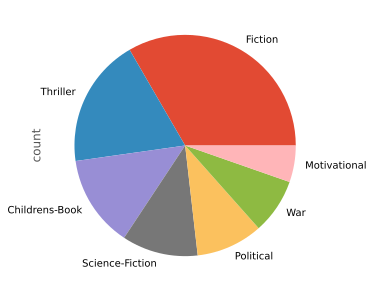

In [49]:
df_org['genre'].value_counts().plot(kind='pie', figsize=(5,5))

BANGLABERT TRAINING

In [50]:
# tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", max_length=512)
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert", max_length=512)

In [51]:
model = AutoModelForSequenceClassification.from_pretrained("csebuetnlp/banglabert", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [61]:
# Splitting df_org

# SIZE= df_org.shape[0]

# train_texts= list(df_org.summary[:SIZE//2])

# val_texts=   list(df_org.summary[SIZE//2:(3*SIZE)//4 ])

# test_texts=  list(df_org.summary[(3*SIZE)//4:])

# train_labels= list(df_org.labels[:SIZE//2])

# val_labels=   list(df_org.labels[SIZE//2:(3*SIZE)//4])

# test_labels=  list(df_org.labels[(3*SIZE)//4:])


from sklearn.model_selection import train_test_split

a = list(df_org.summary)
b = list(df_org.labels)
train_texts, val_texts, train_labels, val_labels = train_test_split(a, b, test_size=0.2, random_state=30)

In [62]:
len(train_texts)

2929

In [63]:
len(train_texts), len(val_texts)

(2929, 733)

In [64]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True, max_length=512)
# test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

In [65]:
class DataLoader(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [66]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

# test_dataset = DataLoader(test_encodings, test_labels)

In [67]:
# Training with Trainer Class
from transformers import TrainingArguments, Trainer

In [68]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [69]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='./ml-comp-cuet-banglabert-results-attempt-2',
    do_train=True,
    do_eval=True,
    #  The number of epochs
    num_train_epochs=7,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    # Number of steps used for a linear warmup
    warmup_steps=37,
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory
    logging_dir='./ml-comp-cuet-banglabert-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    load_best_model_at_end=True
)

In [70]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,
     # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics= compute_metrics
)

In [71]:
torch.cuda.empty_cache()

In [72]:
trainer.train()

  2%|▏         | 50/2569 [02:25<1:50:58,  2.64s/it]

{'loss': 1.8289, 'learning_rate': 4.974328593996841e-05, 'epoch': 0.14}


                                                   

  2%|▏         | 50/2569 [03:36<1:50:58,  2.64s/it]

{'eval_loss': 1.717471957206726, 'eval_Accuracy': 0.34106412005457026, 'eval_F1': 0.07266385699752942, 'eval_Precision': 0.04872344572208147, 'eval_Recall': 0.14285714285714285, 'eval_runtime': 71.0867, 'eval_samples_per_second': 10.311, 'eval_steps_per_second': 0.647, 'epoch': 0.14}


  4%|▍         | 100/2569 [05:50<1:57:58,  2.87s/it]

{'loss': 1.6649, 'learning_rate': 4.8755924170616116e-05, 'epoch': 0.27}


                                                    

  4%|▍         | 100/2569 [07:15<1:57:58,  2.87s/it]

{'eval_loss': 1.4407347440719604, 'eval_Accuracy': 0.44201909959072305, 'eval_F1': 0.21641397608316632, 'eval_Precision': 0.20724735615581555, 'eval_Recall': 0.2930463114307508, 'eval_runtime': 85.184, 'eval_samples_per_second': 8.605, 'eval_steps_per_second': 0.54, 'epoch': 0.27}


  6%|▌         | 150/2569 [09:35<1:51:49,  2.77s/it] 

{'loss': 1.3356, 'learning_rate': 4.7768562401263825e-05, 'epoch': 0.41}


                                                    

  6%|▌         | 150/2569 [11:00<1:51:49,  2.77s/it]

{'eval_loss': 1.1489965915679932, 'eval_Accuracy': 0.6234652114597544, 'eval_F1': 0.45633226814637257, 'eval_Precision': 0.5701642362234701, 'eval_Recall': 0.5051084661102937, 'eval_runtime': 85.134, 'eval_samples_per_second': 8.61, 'eval_steps_per_second': 0.54, 'epoch': 0.41}


  8%|▊         | 200/2569 [13:22<1:57:12,  2.97s/it] 

{'loss': 1.0897, 'learning_rate': 4.6781200631911534e-05, 'epoch': 0.54}


                                                    

  8%|▊         | 200/2569 [14:34<1:57:12,  2.97s/it]

{'eval_loss': 0.9096693992614746, 'eval_Accuracy': 0.7298772169167803, 'eval_F1': 0.6417205244384422, 'eval_Precision': 0.6385097821837193, 'eval_Recall': 0.6889357172245382, 'eval_runtime': 71.2132, 'eval_samples_per_second': 10.293, 'eval_steps_per_second': 0.646, 'epoch': 0.54}


 10%|▉         | 250/2569 [16:32<1:31:21,  2.36s/it] 

{'loss': 0.809, 'learning_rate': 4.579383886255924e-05, 'epoch': 0.68}


                                                    

 10%|▉         | 250/2569 [17:42<1:31:21,  2.36s/it]

{'eval_loss': 0.791333019733429, 'eval_Accuracy': 0.7557980900409277, 'eval_F1': 0.661567556296883, 'eval_Precision': 0.636674958771865, 'eval_Recall': 0.7114064988152498, 'eval_runtime': 69.8878, 'eval_samples_per_second': 10.488, 'eval_steps_per_second': 0.658, 'epoch': 0.68}


 12%|█▏        | 300/2569 [19:40<1:28:54,  2.35s/it] 

{'loss': 0.8433, 'learning_rate': 4.480647709320695e-05, 'epoch': 0.82}


                                                    

 12%|█▏        | 300/2569 [20:49<1:28:54,  2.35s/it]

{'eval_loss': 0.8263717293739319, 'eval_Accuracy': 0.7708049113233287, 'eval_F1': 0.6639179037208193, 'eval_Precision': 0.6652319411615579, 'eval_Recall': 0.6829968171426867, 'eval_runtime': 69.8507, 'eval_samples_per_second': 10.494, 'eval_steps_per_second': 0.659, 'epoch': 0.82}


 14%|█▎        | 350/2569 [27:35<14:23:51, 23.36s/it]

{'loss': 0.7514, 'learning_rate': 4.381911532385466e-05, 'epoch': 0.95}


                                                     

 14%|█▎        | 350/2569 [29:01<14:23:51, 23.36s/it]

{'eval_loss': 0.7352957129478455, 'eval_Accuracy': 0.7858117326057299, 'eval_F1': 0.6935229380289344, 'eval_Precision': 0.6788186330665499, 'eval_Recall': 0.738493534735637, 'eval_runtime': 86.0337, 'eval_samples_per_second': 8.52, 'eval_steps_per_second': 0.535, 'epoch': 0.95}


 16%|█▌        | 400/2569 [31:19<1:44:13,  2.88s/it] 

{'loss': 0.5732, 'learning_rate': 4.283175355450238e-05, 'epoch': 1.09}


                                                    

 16%|█▌        | 400/2569 [32:37<1:44:13,  2.88s/it]

{'eval_loss': 0.7159543633460999, 'eval_Accuracy': 0.781718963165075, 'eval_F1': 0.6954996108489906, 'eval_Precision': 0.7867883511462885, 'eval_Recall': 0.7351545149415264, 'eval_runtime': 78.5895, 'eval_samples_per_second': 9.327, 'eval_steps_per_second': 0.585, 'epoch': 1.09}


 18%|█▊        | 450/2569 [34:45<1:23:43,  2.37s/it] 

{'loss': 0.7506, 'learning_rate': 4.1844391785150086e-05, 'epoch': 1.23}


                                                    

 18%|█▊        | 450/2569 [35:56<1:23:43,  2.37s/it]

{'eval_loss': 0.7422122359275818, 'eval_Accuracy': 0.7994542974079127, 'eval_F1': 0.6993030658985967, 'eval_Precision': 0.6799149580653355, 'eval_Recall': 0.7267235940280647, 'eval_runtime': 70.1444, 'eval_samples_per_second': 10.45, 'eval_steps_per_second': 0.656, 'epoch': 1.23}


 19%|█▉        | 500/2569 [37:53<1:21:38,  2.37s/it] 

{'loss': 0.588, 'learning_rate': 4.0857030015797795e-05, 'epoch': 1.36}


                                                    

 19%|█▉        | 500/2569 [39:04<1:21:38,  2.37s/it]

{'eval_loss': 0.6862167716026306, 'eval_Accuracy': 0.7967257844474761, 'eval_F1': 0.7099053340992408, 'eval_Precision': 0.6966255881451754, 'eval_Recall': 0.7468039908418328, 'eval_runtime': 70.4896, 'eval_samples_per_second': 10.399, 'eval_steps_per_second': 0.653, 'epoch': 1.36}


 21%|██▏       | 550/2569 [41:06<1:23:47,  2.49s/it] 

{'loss': 0.5797, 'learning_rate': 3.9869668246445504e-05, 'epoch': 1.5}


                                                    

 21%|██▏       | 550/2569 [42:15<1:23:47,  2.49s/it]

{'eval_loss': 0.9256213903427124, 'eval_Accuracy': 0.7503410641200545, 'eval_F1': 0.6336296289672385, 'eval_Precision': 0.5999345492085036, 'eval_Recall': 0.6987377519053222, 'eval_runtime': 69.2928, 'eval_samples_per_second': 10.578, 'eval_steps_per_second': 0.664, 'epoch': 1.5}


 23%|██▎       | 600/2569 [44:07<1:12:27,  2.21s/it] 

{'loss': 0.828, 'learning_rate': 3.8882306477093214e-05, 'epoch': 1.63}


                                                    

 23%|██▎       | 600/2569 [45:22<1:12:27,  2.21s/it]

{'eval_loss': 0.7823934555053711, 'eval_Accuracy': 0.772169167803547, 'eval_F1': 0.6913851162604506, 'eval_Precision': 0.673388299689911, 'eval_Recall': 0.7265017792287616, 'eval_runtime': 74.3473, 'eval_samples_per_second': 9.859, 'eval_steps_per_second': 0.619, 'epoch': 1.63}


 25%|██▌       | 650/2569 [47:26<1:26:46,  2.71s/it] 

{'loss': 0.5279, 'learning_rate': 3.789494470774092e-05, 'epoch': 1.77}


                                                    

 25%|██▌       | 650/2569 [48:38<1:26:46,  2.71s/it]

{'eval_loss': 0.6802569627761841, 'eval_Accuracy': 0.8035470668485676, 'eval_F1': 0.7171211283898403, 'eval_Precision': 0.7506351404116814, 'eval_Recall': 0.7547121825834555, 'eval_runtime': 71.4553, 'eval_samples_per_second': 10.258, 'eval_steps_per_second': 0.644, 'epoch': 1.77}


 27%|██▋       | 700/2569 [50:35<1:12:45,  2.34s/it] 

{'loss': 0.5726, 'learning_rate': 3.690758293838863e-05, 'epoch': 1.91}


                                                    

 27%|██▋       | 700/2569 [51:44<1:12:45,  2.34s/it]

{'eval_loss': 0.6487260460853577, 'eval_Accuracy': 0.834924965893588, 'eval_F1': 0.8127456078027827, 'eval_Precision': 0.8121022961819956, 'eval_Recall': 0.8156475876708484, 'eval_runtime': 69.086, 'eval_samples_per_second': 10.61, 'eval_steps_per_second': 0.666, 'epoch': 1.91}


 29%|██▉       | 750/2569 [53:39<1:11:10,  2.35s/it] 

{'loss': 0.5476, 'learning_rate': 3.592022116903634e-05, 'epoch': 2.04}


                                                    

 29%|██▉       | 750/2569 [54:48<1:11:10,  2.35s/it]

{'eval_loss': 0.6781088709831238, 'eval_Accuracy': 0.8458390177353342, 'eval_F1': 0.816856968529832, 'eval_Precision': 0.8403853291484914, 'eval_Recall': 0.816228977591079, 'eval_runtime': 69.06, 'eval_samples_per_second': 10.614, 'eval_steps_per_second': 0.666, 'epoch': 2.04}


 31%|███       | 800/2569 [56:45<1:09:36,  2.36s/it] 

{'loss': 0.4004, 'learning_rate': 3.493285939968405e-05, 'epoch': 2.18}


                                                    

 31%|███       | 800/2569 [57:54<1:09:36,  2.36s/it]

{'eval_loss': 0.666664719581604, 'eval_Accuracy': 0.8144611186903138, 'eval_F1': 0.7854401680172088, 'eval_Precision': 0.7940647979473238, 'eval_Recall': 0.8044359956981113, 'eval_runtime': 69.2811, 'eval_samples_per_second': 10.58, 'eval_steps_per_second': 0.664, 'epoch': 2.18}


 33%|███▎      | 850/2569 [59:52<1:08:11,  2.38s/it] 

{'loss': 0.5626, 'learning_rate': 3.394549763033176e-05, 'epoch': 2.32}


                                                    

 33%|███▎      | 850/2569 [1:01:02<1:08:11,  2.38s/it]

{'eval_loss': 0.7187795042991638, 'eval_Accuracy': 0.8090040927694406, 'eval_F1': 0.7232565381380341, 'eval_Precision': 0.7596719432080387, 'eval_Recall': 0.7627022282384974, 'eval_runtime': 69.3738, 'eval_samples_per_second': 10.566, 'eval_steps_per_second': 0.663, 'epoch': 2.32}


 35%|███▌      | 900/2569 [1:02:58<1:05:15,  2.35s/it] 

{'loss': 0.4326, 'learning_rate': 3.295813586097947e-05, 'epoch': 2.45}


                                                      

 35%|███▌      | 900/2569 [1:04:09<1:05:15,  2.35s/it]

{'eval_loss': 0.6377676129341125, 'eval_Accuracy': 0.8553888130968622, 'eval_F1': 0.8427369015223916, 'eval_Precision': 0.8359804863143699, 'eval_Recall': 0.8573373640887031, 'eval_runtime': 70.6367, 'eval_samples_per_second': 10.377, 'eval_steps_per_second': 0.651, 'epoch': 2.45}


 37%|███▋      | 950/2569 [1:06:07<1:03:03,  2.34s/it] 

{'loss': 0.4947, 'learning_rate': 3.197077409162718e-05, 'epoch': 2.59}


                                                      

 37%|███▋      | 950/2569 [1:07:16<1:03:03,  2.34s/it]

{'eval_loss': 0.6011033654212952, 'eval_Accuracy': 0.8540245566166439, 'eval_F1': 0.842080645265051, 'eval_Precision': 0.8547111451085677, 'eval_Recall': 0.8373224824627622, 'eval_runtime': 69.1702, 'eval_samples_per_second': 10.597, 'eval_steps_per_second': 0.665, 'epoch': 2.59}


 39%|███▉      | 1000/2569 [1:09:13<1:01:18,  2.34s/it]

{'loss': 0.3586, 'learning_rate': 3.0983412322274886e-05, 'epoch': 2.72}


                                                       

 39%|███▉      | 1000/2569 [1:10:22<1:01:18,  2.34s/it]

{'eval_loss': 0.6308729648590088, 'eval_Accuracy': 0.8676671214188267, 'eval_F1': 0.8480175442177377, 'eval_Precision': 0.8620211393916984, 'eval_Recall': 0.839646113763587, 'eval_runtime': 69.2901, 'eval_samples_per_second': 10.579, 'eval_steps_per_second': 0.664, 'epoch': 2.72}


 41%|████      | 1050/2569 [1:12:21<59:11,  2.34s/it]   

{'loss': 0.3693, 'learning_rate': 2.9996050552922595e-05, 'epoch': 2.86}


                                                     

 41%|████      | 1050/2569 [1:13:30<59:11,  2.34s/it]

{'eval_loss': 0.6610651016235352, 'eval_Accuracy': 0.8526603001364257, 'eval_F1': 0.8208898000675175, 'eval_Precision': 0.8227531869366208, 'eval_Recall': 0.8351652255804928, 'eval_runtime': 69.3265, 'eval_samples_per_second': 10.573, 'eval_steps_per_second': 0.664, 'epoch': 2.86}


 43%|████▎     | 1100/2569 [1:15:27<57:08,  2.33s/it]  

{'loss': 0.503, 'learning_rate': 2.9008688783570304e-05, 'epoch': 3.0}


                                                     

 43%|████▎     | 1100/2569 [1:16:36<57:08,  2.33s/it]

{'eval_loss': 0.6115626692771912, 'eval_Accuracy': 0.8676671214188267, 'eval_F1': 0.8563714772400625, 'eval_Precision': 0.8626211810114903, 'eval_Recall': 0.852270011440892, 'eval_runtime': 69.0351, 'eval_samples_per_second': 10.618, 'eval_steps_per_second': 0.666, 'epoch': 3.0}


 45%|████▍     | 1150/2569 [1:18:31<55:26,  2.34s/it]  

{'loss': 0.3177, 'learning_rate': 2.8021327014218013e-05, 'epoch': 3.13}


                                                     

 45%|████▍     | 1150/2569 [1:19:47<55:26,  2.34s/it]

{'eval_loss': 0.6319394111633301, 'eval_Accuracy': 0.8676671214188267, 'eval_F1': 0.8451982947734107, 'eval_Precision': 0.8547367237832721, 'eval_Recall': 0.8390576257511675, 'eval_runtime': 76.0734, 'eval_samples_per_second': 9.635, 'eval_steps_per_second': 0.605, 'epoch': 3.13}


 47%|████▋     | 1200/2569 [1:21:46<54:08,  2.37s/it]  

{'loss': 0.2742, 'learning_rate': 2.7033965244865722e-05, 'epoch': 3.27}


                                                     

 47%|████▋     | 1200/2569 [1:22:57<54:08,  2.37s/it]

{'eval_loss': 0.6711156964302063, 'eval_Accuracy': 0.8526603001364257, 'eval_F1': 0.8167847120792951, 'eval_Precision': 0.8367600267832461, 'eval_Recall': 0.8110183655631079, 'eval_runtime': 70.876, 'eval_samples_per_second': 10.342, 'eval_steps_per_second': 0.649, 'epoch': 3.27}


 49%|████▊     | 1250/2569 [1:24:58<52:53,  2.41s/it]  

{'loss': 0.3512, 'learning_rate': 2.604660347551343e-05, 'epoch': 3.41}


                                                     

 49%|████▊     | 1250/2569 [1:26:14<52:53,  2.41s/it]

{'eval_loss': 0.676965594291687, 'eval_Accuracy': 0.8608458390177354, 'eval_F1': 0.8372989020721456, 'eval_Precision': 0.8510195374279546, 'eval_Recall': 0.8280496934115531, 'eval_runtime': 76.713, 'eval_samples_per_second': 9.555, 'eval_steps_per_second': 0.6, 'epoch': 3.41}


 51%|█████     | 1300/2569 [1:28:11<49:50,  2.36s/it]  

{'loss': 0.2346, 'learning_rate': 2.505924170616114e-05, 'epoch': 3.54}


                                                     

 51%|█████     | 1300/2569 [1:29:20<49:50,  2.36s/it]

{'eval_loss': 0.64946049451828, 'eval_Accuracy': 0.8635743519781719, 'eval_F1': 0.8392991789478395, 'eval_Precision': 0.8390505458138302, 'eval_Recall': 0.8433793901821971, 'eval_runtime': 69.4241, 'eval_samples_per_second': 10.558, 'eval_steps_per_second': 0.663, 'epoch': 3.54}


 53%|█████▎    | 1350/2569 [1:31:22<44:14,  2.18s/it]  

{'loss': 0.4368, 'learning_rate': 2.4071879936808846e-05, 'epoch': 3.68}


                                                     

 53%|█████▎    | 1350/2569 [1:32:40<44:14,  2.18s/it]

{'eval_loss': 0.594160258769989, 'eval_Accuracy': 0.8703956343792633, 'eval_F1': 0.8555905458843175, 'eval_Precision': 0.8557343529366035, 'eval_Recall': 0.8593435528930398, 'eval_runtime': 77.2987, 'eval_samples_per_second': 9.483, 'eval_steps_per_second': 0.595, 'epoch': 3.68}


 54%|█████▍    | 1400/2569 [1:34:39<46:07,  2.37s/it]  

{'loss': 0.3158, 'learning_rate': 2.3084518167456555e-05, 'epoch': 3.81}


                                                     

 54%|█████▍    | 1400/2569 [1:35:53<46:07,  2.37s/it]

{'eval_loss': 0.6378338932991028, 'eval_Accuracy': 0.8663028649386084, 'eval_F1': 0.844992197009565, 'eval_Precision': 0.8417939420112839, 'eval_Recall': 0.8525527412491257, 'eval_runtime': 74.533, 'eval_samples_per_second': 9.835, 'eval_steps_per_second': 0.617, 'epoch': 3.81}


 56%|█████▋    | 1450/2569 [1:37:54<40:29,  2.17s/it]  

{'loss': 0.3673, 'learning_rate': 2.2097156398104264e-05, 'epoch': 3.95}


                                                     

 56%|█████▋    | 1450/2569 [1:39:14<40:29,  2.17s/it]

{'eval_loss': 0.6666145324707031, 'eval_Accuracy': 0.8540245566166439, 'eval_F1': 0.8356272030501722, 'eval_Precision': 0.8381332463763328, 'eval_Recall': 0.845367583985518, 'eval_runtime': 80.0411, 'eval_samples_per_second': 9.158, 'eval_steps_per_second': 0.575, 'epoch': 3.95}


 58%|█████▊    | 1500/2569 [1:41:11<42:20,  2.38s/it]  

{'loss': 0.2975, 'learning_rate': 2.1109794628751973e-05, 'epoch': 4.09}


                                                     

 58%|█████▊    | 1500/2569 [1:42:22<42:20,  2.38s/it]

{'eval_loss': 0.6327667236328125, 'eval_Accuracy': 0.8663028649386084, 'eval_F1': 0.8455604315101934, 'eval_Precision': 0.8478920032398624, 'eval_Recall': 0.8443382023224154, 'eval_runtime': 71.2777, 'eval_samples_per_second': 10.284, 'eval_steps_per_second': 0.645, 'epoch': 4.09}


 60%|██████    | 1550/2569 [1:44:24<40:28,  2.38s/it]  

{'loss': 0.247, 'learning_rate': 2.0122432859399686e-05, 'epoch': 4.22}


                                                     

 60%|██████    | 1550/2569 [1:45:35<40:28,  2.38s/it]

{'eval_loss': 0.6403207182884216, 'eval_Accuracy': 0.869031377899045, 'eval_F1': 0.851587259341963, 'eval_Precision': 0.8539505794595261, 'eval_Recall': 0.8499689212500658, 'eval_runtime': 70.8263, 'eval_samples_per_second': 10.349, 'eval_steps_per_second': 0.649, 'epoch': 4.22}


 62%|██████▏   | 1600/2569 [1:47:35<39:17,  2.43s/it]  

{'loss': 0.2325, 'learning_rate': 1.9135071090047395e-05, 'epoch': 4.36}


                                                     

 62%|██████▏   | 1600/2569 [1:48:47<39:17,  2.43s/it]

{'eval_loss': 0.609904408454895, 'eval_Accuracy': 0.8717598908594816, 'eval_F1': 0.8566654440651399, 'eval_Precision': 0.8554139024240461, 'eval_Recall': 0.8623637158116116, 'eval_runtime': 72.321, 'eval_samples_per_second': 10.135, 'eval_steps_per_second': 0.636, 'epoch': 4.36}


 64%|██████▍   | 1650/2569 [1:50:48<37:31,  2.45s/it]  

{'loss': 0.1506, 'learning_rate': 1.8147709320695104e-05, 'epoch': 4.5}


                                                     

 64%|██████▍   | 1650/2569 [1:52:00<37:31,  2.45s/it]

{'eval_loss': 0.6452308893203735, 'eval_Accuracy': 0.8758526603001364, 'eval_F1': 0.8595642478848825, 'eval_Precision': 0.8558829831099005, 'eval_Recall': 0.8647979219440536, 'eval_runtime': 71.385, 'eval_samples_per_second': 10.268, 'eval_steps_per_second': 0.644, 'epoch': 4.5}


 66%|██████▌   | 1700/2569 [1:53:59<34:32,  2.38s/it]  

{'loss': 0.2995, 'learning_rate': 1.7160347551342813e-05, 'epoch': 4.63}


                                                     

 66%|██████▌   | 1700/2569 [1:55:10<34:32,  2.38s/it]

{'eval_loss': 0.6326658129692078, 'eval_Accuracy': 0.8663028649386084, 'eval_F1': 0.8518618144455891, 'eval_Precision': 0.8530124427266745, 'eval_Recall': 0.8546230275492596, 'eval_runtime': 71.067, 'eval_samples_per_second': 10.314, 'eval_steps_per_second': 0.647, 'epoch': 4.63}


 68%|██████▊   | 1750/2569 [1:57:10<32:21,  2.37s/it]  

{'loss': 0.1681, 'learning_rate': 1.6172985781990522e-05, 'epoch': 4.77}


                                                     

 68%|██████▊   | 1750/2569 [1:58:21<32:21,  2.37s/it]

{'eval_loss': 0.661795973777771, 'eval_Accuracy': 0.878581173260573, 'eval_F1': 0.8637599796915802, 'eval_Precision': 0.8657800552499142, 'eval_Recall': 0.8648483754731008, 'eval_runtime': 70.92, 'eval_samples_per_second': 10.336, 'eval_steps_per_second': 0.649, 'epoch': 4.77}


 70%|███████   | 1800/2569 [2:00:20<30:29,  2.38s/it]  

{'loss': 0.2451, 'learning_rate': 1.5185624012638231e-05, 'epoch': 4.9}


                                                     

 70%|███████   | 1800/2569 [2:01:31<30:29,  2.38s/it]

{'eval_loss': 0.6799260377883911, 'eval_Accuracy': 0.8663028649386084, 'eval_F1': 0.845359012694433, 'eval_Precision': 0.8541283308244731, 'eval_Recall': 0.8404830853986688, 'eval_runtime': 71.266, 'eval_samples_per_second': 10.285, 'eval_steps_per_second': 0.645, 'epoch': 4.9}


 72%|███████▏  | 1850/2569 [2:03:29<28:33,  2.38s/it]  

{'loss': 0.2576, 'learning_rate': 1.419826224328594e-05, 'epoch': 5.04}


                                                     

 72%|███████▏  | 1850/2569 [2:04:39<28:33,  2.38s/it]

{'eval_loss': 0.6750640273094177, 'eval_Accuracy': 0.8703956343792633, 'eval_F1': 0.8552341248689607, 'eval_Precision': 0.8555244287387145, 'eval_Recall': 0.8557149165256955, 'eval_runtime': 70.6794, 'eval_samples_per_second': 10.371, 'eval_steps_per_second': 0.651, 'epoch': 5.04}


 74%|███████▍  | 1900/2569 [2:06:39<26:35,  2.38s/it]  

{'loss': 0.1318, 'learning_rate': 1.321090047393365e-05, 'epoch': 5.18}


                                                     

 74%|███████▍  | 1900/2569 [2:07:53<26:35,  2.38s/it]

{'eval_loss': 0.7062837481498718, 'eval_Accuracy': 0.8608458390177354, 'eval_F1': 0.8495767412875065, 'eval_Precision': 0.849312853581466, 'eval_Recall': 0.8540789862866828, 'eval_runtime': 74.074, 'eval_samples_per_second': 9.896, 'eval_steps_per_second': 0.621, 'epoch': 5.18}


 76%|███████▌  | 1950/2569 [2:09:54<24:41,  2.39s/it]  

{'loss': 0.165, 'learning_rate': 1.222353870458136e-05, 'epoch': 5.31}


                                                     

 76%|███████▌  | 1950/2569 [2:11:05<24:41,  2.39s/it]

{'eval_loss': 0.6696046590805054, 'eval_Accuracy': 0.8703956343792633, 'eval_F1': 0.8553904651165436, 'eval_Precision': 0.8590091317049166, 'eval_Recall': 0.8552718293026947, 'eval_runtime': 70.946, 'eval_samples_per_second': 10.332, 'eval_steps_per_second': 0.648, 'epoch': 5.31}


 78%|███████▊  | 2000/2569 [2:13:04<22:43,  2.40s/it]  

{'loss': 0.1537, 'learning_rate': 1.1236176935229069e-05, 'epoch': 5.45}


                                                     

 78%|███████▊  | 2000/2569 [2:14:15<22:43,  2.40s/it]

{'eval_loss': 0.6640238761901855, 'eval_Accuracy': 0.8717598908594816, 'eval_F1': 0.8547153441722344, 'eval_Precision': 0.8625955971913252, 'eval_Recall': 0.8481955854426075, 'eval_runtime': 71.3153, 'eval_samples_per_second': 10.278, 'eval_steps_per_second': 0.645, 'epoch': 5.45}


 80%|███████▉  | 2050/2569 [2:16:16<20:36,  2.38s/it]  

{'loss': 0.1816, 'learning_rate': 1.0248815165876778e-05, 'epoch': 5.59}


                                                     

 80%|███████▉  | 2050/2569 [2:17:27<20:36,  2.38s/it]

{'eval_loss': 0.6759787201881409, 'eval_Accuracy': 0.8717598908594816, 'eval_F1': 0.8509268407038534, 'eval_Precision': 0.851901797192837, 'eval_Recall': 0.850952281409552, 'eval_runtime': 71.1374, 'eval_samples_per_second': 10.304, 'eval_steps_per_second': 0.647, 'epoch': 5.59}


 82%|████████▏ | 2100/2569 [2:19:26<18:33,  2.38s/it]  

{'loss': 0.1685, 'learning_rate': 9.261453396524487e-06, 'epoch': 5.72}


                                                     

 82%|████████▏ | 2100/2569 [2:20:41<18:33,  2.38s/it]

{'eval_loss': 0.7007232308387756, 'eval_Accuracy': 0.8676671214188267, 'eval_F1': 0.8496516063098399, 'eval_Precision': 0.8501702734521087, 'eval_Recall': 0.8529230785480788, 'eval_runtime': 75.564, 'eval_samples_per_second': 9.7, 'eval_steps_per_second': 0.609, 'epoch': 5.72}


 84%|████████▎ | 2150/2569 [2:22:52<15:12,  2.18s/it]  

{'loss': 0.1949, 'learning_rate': 8.274091627172196e-06, 'epoch': 5.86}


                                                     

 84%|████████▎ | 2150/2569 [2:24:13<15:12,  2.18s/it]

{'eval_loss': 0.6939690113067627, 'eval_Accuracy': 0.8744884038199181, 'eval_F1': 0.8556815867957568, 'eval_Precision': 0.8506847141777235, 'eval_Recall': 0.863293635862609, 'eval_runtime': 80.2576, 'eval_samples_per_second': 9.133, 'eval_steps_per_second': 0.573, 'epoch': 5.86}


 86%|████████▌ | 2200/2569 [2:26:32<14:41,  2.39s/it]  

{'loss': 0.1225, 'learning_rate': 7.286729857819906e-06, 'epoch': 5.99}


                                                     

 86%|████████▌ | 2200/2569 [2:27:42<14:41,  2.39s/it]

{'eval_loss': 0.6815425157546997, 'eval_Accuracy': 0.8717598908594816, 'eval_F1': 0.8500580830916306, 'eval_Precision': 0.8442360859205917, 'eval_Recall': 0.8565422828463092, 'eval_runtime': 69.4209, 'eval_samples_per_second': 10.559, 'eval_steps_per_second': 0.663, 'epoch': 5.99}


 88%|████████▊ | 2250/2569 [2:29:38<12:28,  2.35s/it]  

{'loss': 0.123, 'learning_rate': 6.299368088467615e-06, 'epoch': 6.13}


                                                     

 88%|████████▊ | 2250/2569 [2:30:47<12:28,  2.35s/it]

{'eval_loss': 0.6868464946746826, 'eval_Accuracy': 0.869031377899045, 'eval_F1': 0.847048417131567, 'eval_Precision': 0.845377223635528, 'eval_Recall': 0.849434665490371, 'eval_runtime': 69.0963, 'eval_samples_per_second': 10.608, 'eval_steps_per_second': 0.666, 'epoch': 6.13}


 90%|████████▉ | 2300/2569 [2:32:46<10:34,  2.36s/it]  

{'loss': 0.1175, 'learning_rate': 5.312006319115324e-06, 'epoch': 6.27}


                                                     

 90%|████████▉ | 2300/2569 [2:33:53<10:34,  2.36s/it]

{'eval_loss': 0.7042397856712341, 'eval_Accuracy': 0.8703956343792633, 'eval_F1': 0.8494594317162647, 'eval_Precision': 0.8454847883966072, 'eval_Recall': 0.8544956070169507, 'eval_runtime': 67.3938, 'eval_samples_per_second': 10.876, 'eval_steps_per_second': 0.683, 'epoch': 6.27}


 91%|█████████▏| 2350/2569 [2:35:54<08:33,  2.35s/it]  

{'loss': 0.0638, 'learning_rate': 4.324644549763033e-06, 'epoch': 6.4}


                                                     

 91%|█████████▏| 2350/2569 [2:37:03<08:33,  2.35s/it]

{'eval_loss': 0.7198107242584229, 'eval_Accuracy': 0.8663028649386084, 'eval_F1': 0.8451346196763491, 'eval_Precision': 0.8438441842210397, 'eval_Recall': 0.8482205793542906, 'eval_runtime': 69.2076, 'eval_samples_per_second': 10.591, 'eval_steps_per_second': 0.665, 'epoch': 6.4}


 93%|█████████▎| 2400/2569 [2:39:01<06:36,  2.34s/it]  

{'loss': 0.1518, 'learning_rate': 3.337282780410743e-06, 'epoch': 6.54}


                                                     

 93%|█████████▎| 2400/2569 [2:40:10<06:36,  2.34s/it]

{'eval_loss': 0.7166382670402527, 'eval_Accuracy': 0.8703956343792633, 'eval_F1': 0.8497267078493481, 'eval_Precision': 0.845421338174763, 'eval_Recall': 0.8548829512163756, 'eval_runtime': 69.3681, 'eval_samples_per_second': 10.567, 'eval_steps_per_second': 0.663, 'epoch': 6.54}


 95%|█████████▌| 2450/2569 [2:42:07<04:37,  2.33s/it]  

{'loss': 0.112, 'learning_rate': 2.349921011058452e-06, 'epoch': 6.68}


                                                     

 95%|█████████▌| 2450/2569 [2:43:22<04:37,  2.33s/it]

{'eval_loss': 0.7069506645202637, 'eval_Accuracy': 0.8676671214188267, 'eval_F1': 0.845179990337447, 'eval_Precision': 0.8421253327727162, 'eval_Recall': 0.8487177998899338, 'eval_runtime': 74.9297, 'eval_samples_per_second': 9.783, 'eval_steps_per_second': 0.614, 'epoch': 6.68}


 97%|█████████▋| 2500/2569 [2:45:19<02:41,  2.34s/it]

{'loss': 0.1212, 'learning_rate': 1.3625592417061611e-06, 'epoch': 6.81}


                                                     

 97%|█████████▋| 2500/2569 [2:46:48<02:41,  2.34s/it]

{'eval_loss': 0.7113196849822998, 'eval_Accuracy': 0.869031377899045, 'eval_F1': 0.8474486427601672, 'eval_Precision': 0.843024359376922, 'eval_Recall': 0.8525788037509378, 'eval_runtime': 88.2651, 'eval_samples_per_second': 8.305, 'eval_steps_per_second': 0.521, 'epoch': 6.81}


 99%|█████████▉| 2550/2569 [2:49:26<00:57,  3.03s/it]

{'loss': 0.1826, 'learning_rate': 3.7519747235387047e-07, 'epoch': 6.95}


                                                     

 99%|█████████▉| 2550/2569 [2:50:50<00:57,  3.03s/it]

{'eval_loss': 0.7156963348388672, 'eval_Accuracy': 0.869031377899045, 'eval_F1': 0.8476067121528342, 'eval_Precision': 0.8433621372216132, 'eval_Recall': 0.8525788037509378, 'eval_runtime': 83.7711, 'eval_samples_per_second': 8.75, 'eval_steps_per_second': 0.549, 'epoch': 6.95}


100%|██████████| 2569/2569 [2:51:35<00:00,  4.01s/it]

{'train_runtime': 10295.051, 'train_samples_per_second': 1.992, 'train_steps_per_second': 0.25, 'train_loss': 0.44075939246029555, 'epoch': 7.0}


TrainOutput(global_step=2569, training_loss=0.44075939246029555, metrics={'train_runtime': 10295.051, 'train_samples_per_second': 1.992, 'train_steps_per_second': 0.25, 'train_loss': 0.44075939246029555, 'epoch': 7.0})

MODEL EVALUATION

In [73]:
q=[trainer.evaluate(eval_dataset=df_org) for df_org in [train_dataloader, val_dataloader]]

pd.DataFrame(q, index=["train","val"]).iloc[:,:5]

100%|██████████| 184/184 [05:54<00:00,  1.93s/it]

100%|██████████| 46/46 [01:23<00:00,  1.82s/it]


,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.333499,0.917378,0.902204,0.905003,0.901050
val,0.630873,0.867667,0.848018,0.862021,0.839646


PREDICTION

In [74]:
def predict(text):
    # Tokenize the input text and move tensors to the GPU if available
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")

    # Get model output (logits)
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)

    # Get the index of the class with the highest probability
    # argmax() finds the index of the maximum value in the tensor along a specified dimension.
    # By default, if no dimension is specified, it returns the index of the maximum value in the flattened tensor.
    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label 
    # Since pred_label_idx is a tensor containing a single value (the predicted class index), 
    # the .item() method is used to extract the value as a scalar
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [75]:
# Test with a an example text
text = "অনেক সুন্দর এবং অসাধারণ একটি বই....  মধ্যবিত্ত পরিবারের সুখ, দু:খ, আনন্দ, কষ্ট নিয়ে লেখা একটি বই.. ভালো লাগবে সবারই।"
predict(text)

(tensor([[9.8808e-01, 3.0662e-03, 2.9888e-03, 8.5556e-04, 4.6556e-04, 3.9601e-03,
          5.8403e-04]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor(0, device='cuda:0'),
 'Fiction')

MODEL SAVE

In [76]:
model_path = "ml-comp-cuet-trained-attempt-2"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('ml-comp-cuet-trained-attempt-2\\tokenizer_config.json',
 'ml-comp-cuet-trained-attempt-2\\special_tokens_map.json',
 'ml-comp-cuet-trained-attempt-2\\vocab.txt',
 'ml-comp-cuet-trained-attempt-2\\added_tokens.json',
 'ml-comp-cuet-trained-attempt-2\\tokenizer.json')

MODEL LOADING AND MAKING A PIPELINE

In [79]:
from transformers import pipeline

model_path = "ml-comp-cuet-trained-attempt-2"


model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer= AutoTokenizer.from_pretrained(model_path)
nlp= pipeline("text-classification", model=model, tokenizer=tokenizer, truncation=True, padding=True, max_length=512)

In [80]:
nlp("বিংশ শতাব্দীর বাঙালি জনপ্রিয় কথাসাহিত্যিকদের মধ্যে অন্যতম। তাঁকে বাংলাদেশের স্বাধীনতা পরবর্তী শ্রেষ্ঠ লেখক গণ্য করা হয়। তিনি একাধারে ঔপন্যাসিক, ছোটগল্পকার, নাট্যকার এবং গীতিকার। বলা হয় আধুনিক বাংলা কল্পবিজ্ঞান সাহিত্যের তিনি পথিকৃৎ। নাটক ও চলচ্চিত্র পরিচালক হিসাবেও তিনি সমাদৃত। তাঁর প্রকাশিত গ্রন্থের সংখ্যা দুই শতাধিক। বাংলা কথাসাহিত্যে তিনি সংলাপপ্রধান নতুন শৈলীর জনক। তাঁর বেশ কিছু গ্রন্থ পৃথিবীর নানা ভাষায় অনূদিত হয়েছে, বেশ কিছু গ্রন্থ স্কুল-কলেজ বিশ্ববিদ্যালয়ের পাঠ্যসূচীর অন্তর্ভুক্ত। সত্তর দশকের শেষভাগে থেকে শুরু করে মৃত্যু অবধি তিনি ছিলেন বাংলা গল্প-উপন্যাসের অপ্রতিদ্বন্দ্বী কারিগর। এই কালপর্বে তাঁর গল্প-উপন্যাসের জনপ্রিয়তা ছিল তুলনারহিত। তাঁর সৃষ্ট হিমু ও মিসির আলি চরিত্রগুলি বাংলাদেশের যুবকশ্রেণীকে গভীরভাবে উদ্বেলিত করেছে। তাঁর নির্মিত চলচ্চিত্রসমূহ পেয়েছে অসামান্য দর্শকপ্রিয়তা। তবে তাঁর টেলিভিশন নাটকগুলি ছিল সর্বাধিক জনপ্রিয়। সংখ্যায় বেশী না হলেও তাঁর রচিত গানগুলোও সবিশেষ জনপ্রিয়তা লাভ করে। তাঁর অন্যতম উপন্যাস হলো নন্দিত নরকে, মধ্যাহ্ন, জোছনা ও জননীর গল্প, মাতাল হাওয়া ইত্যাদি। তাঁর নির্মিত কয়েকটি চলচ্চিত্র হলো দুই দুয়ারী, শ্রাবণ মেঘের দিন, ঘেঁটুপুত্র কমলা ইত্যাদি। তেমনি দ্বীপ ও তার একটি অস্মান্য সৃষ্টি ।")

[{'label': 'Fiction', 'score': 0.9898721575737}]

TEST FILE PREDICTION AND LABELING

In [82]:
test_df = pd.read_csv("../test.csv")

# for i in test_df['summary']:
#     pred_label = nlp(i)
#     print(pred_label)

nlp(test_df['summary'][1])

[{'label': 'Thriller', 'score': 0.9424118995666504}]

In [83]:
test_df['Label'] = ''

for index, row in test_df.iterrows():
    summary_text = row['summary']
    predictions = nlp(summary_text)
    test_df.at[index, 'Label'] = predictions[0]['label']


test_df.to_csv('test_with_predictions.csv', index=False)

In [89]:
test_predicted = pd.read_csv("test_with_predictions.csv")
test_predicted

,Id,summary,Label
0,0,আমার কোন উপন্যাস তখনি ভাল লাগে যখন আমি এর চরিত...,Fiction
1,1,বইঃ দ্য সান অফ লাইট (রামেসিস #1) লেখকঃ ক্রিশ্চ...,Thriller
2,2,বাংলাদেশ আমার জন্মভূমি। সাতপুরুষের ভিটে-মাটি। ...,Fiction
3,3,বিংশ শতাব্দীর বাঙালি জনপ্রিয় কথাসাহিত্যিকদের ...,Fiction
4,4,অনেক সুন্দর এবং অসাধারণ একটি বই.... মধ্যবিত্ত...,Fiction
...,...,...,...
682,682,বইটির কাহিনী আবর্তিত হয়েছে যুক্তরাষ্ট্রের দুই ...,Science-Fiction
683,683,"ফরাসি বিপ্লব মানে বুর্জোয়া বিপ্লব, আদি সমাজতা...",Political
684,684,শুভ্র চরিত্রটি আমরা প্রথম দেখতে পাই ‘দারুচিনি...,Fiction
685,685,রকমারি_রিভিউ_প্রতিযোগিতা_জুন\r\n\r\nপালোমিনো ম...,Thriller


In [90]:
test_predicted["Label-No"] = test_predicted['Label'].map(lambda x: label2id[x.strip()])

In [91]:
test_predicted

,Id,summary,Label,Label-No
0,0,আমার কোন উপন্যাস তখনি ভাল লাগে যখন আমি এর চরিত...,Fiction,0
1,1,বইঃ দ্য সান অফ লাইট (রামেসিস #1) লেখকঃ ক্রিশ্চ...,Thriller,1
2,2,বাংলাদেশ আমার জন্মভূমি। সাতপুরুষের ভিটে-মাটি। ...,Fiction,0
3,3,বিংশ শতাব্দীর বাঙালি জনপ্রিয় কথাসাহিত্যিকদের ...,Fiction,0
4,4,অনেক সুন্দর এবং অসাধারণ একটি বই.... মধ্যবিত্ত...,Fiction,0
...,...,...,...,...
682,682,বইটির কাহিনী আবর্তিত হয়েছে যুক্তরাষ্ট্রের দুই ...,Science-Fiction,4
683,683,"ফরাসি বিপ্লব মানে বুর্জোয়া বিপ্লব, আদি সমাজতা...",Political,3
684,684,শুভ্র চরিত্রটি আমরা প্রথম দেখতে পাই ‘দারুচিনি...,Fiction,0
685,685,রকমারি_রিভিউ_প্রতিযোগিতা_জুন\r\n\r\nপালোমিনো ম...,Thriller,1


In [92]:
columns_to_drop = ['summary','Label']
test_predicted = test_predicted.drop(columns=columns_to_drop)
test_predicted

,Id,Label-No
0,0,0
1,1,1
2,2,0
3,3,0
4,4,0
...,...,...
682,682,4
683,683,3
684,684,0
685,685,1


In [93]:
test_predicted.rename(columns={'Label-No': 'Label'}, inplace=True)
test_predicted

,Id,Label
0,0,0
1,1,1
2,2,0
3,3,0
4,4,0
...,...,...
682,682,4
683,683,3
684,684,0
685,685,1


In [108]:
test_predicted.to_csv('Bengali Warlords v2.csv', index=False)